In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import sys
import os
import glob
from scipy.misc import imresize
from scipy.misc import imsave
import multiprocessing

train_val_root = '/usr/stud/wangyu/DAVIS17_train_val'
test_dev_root = '/usr/stud/wangyu/DAVIS17_test_dev'
test_challenge_root = '/usr/stud/wangyu/DAVIS17_test_challenge'
train_list_txt = '/usr/stud/wangyu/DAVIS17_train_val/ImageSets/2017/train.txt'
val_list_txt = '/usr/stud/wangyu/DAVIS17_train_val/ImageSets/2017/val.txt'
NUM_PROCESSES = 3

def get_file_list(train_val_root, train_list_txt, val_list_txt, test_dev_root, test_challenge_root):
    'Get all RGB images and corresponding labels'
    # create train, val, test_dev, test_challenge list files
    train_list = open('train_list.txt','w')
    train_gt_list = open('train_gt_list.txt', 'w')
    val_list = open('val_list.txt', 'w')
    val_gt_list = open('val_gt_list.txt', 'w')
    
    # train, val, test_dev, test_challenge file lists
    files_train_img = []
    files_train_gts = []
    files_val_img = []
    files_val_gts = []
    files_dev_img = []
    files_challenge_img = []
    
    # train list
    with open(train_list_txt) as t:
        train_seqs = t.read().splitlines()
    for i in range(len(train_seqs)):
        seq = train_seqs[i]
        search_seq_imgs = os.path.join( train_val_root , "JPEGImages" , "480p" , seq , "*.jpg" )
        search_seq_gts = os.path.join( train_val_root , "Annotations" , "480p" , seq , "*.png" )
        files_seq_imgs = glob.glob(search_seq_imgs)
        files_seq_gts = glob.glob(search_seq_gts)
        files_seq_imgs.sort()
        files_seq_gts.sort()
        if len(files_seq_imgs) != len(files_seq_gts):
            sys.exit('Sequence {} train/gt lenght do not match.'.format(seq))
        files_train_img += files_seq_imgs
        files_train_gts += files_seq_gts
        for j in range(len(files_seq_imgs)):
            train_list.write("%s\n" % files_seq_imgs[j])
            train_gt_list.write("%s\n" % files_seq_gts[j])
    train_list.close()
    train_gt_list.close()
    # grouping train/gt pairs
    train_pair_list = []
    for i in range(len(files_train_img)):
        train_pair_list.append([files_train_img[i], files_train_gts[i]])
    
    # val list
    with open(val_list_txt) as t:
        val_seqs = t.read().splitlines()
    for i in range(len(val_seqs)):
        seq = val_seqs[i]
        search_seq_imgs = os.path.join( train_val_root , "JPEGImages" , "480p" , seq , "*.jpg" )
        search_seq_gts = os.path.join( train_val_root , "Annotations" , "480p" , seq , "*.png" )
        files_seq_imgs = glob.glob(search_seq_imgs)
        files_seq_gts = glob.glob(search_seq_gts)
        files_seq_imgs.sort()
        files_seq_gts.sort()
        if len(files_seq_imgs) != len(files_seq_gts):
            sys.exit('Sequence {} train/gt lenght do not match.'.format(seq))
        files_val_img += files_seq_imgs
        files_val_gts += files_seq_gts
        for j in range(len(files_seq_imgs)):
            val_list.write("%s\n" % files_seq_imgs[j])
            val_gt_list.write("%s\n" % files_seq_gts[j])
    val_list.close()
    val_gt_list.close()
    # grouping val/gt pairs
    val_pair_list = []
    for i in range(len(files_val_img)):
        val_pair_list.append([files_val_img[i], files_val_gts[i]])
    print('Got {0} train/gt files. {1} val files.'.format(len(train_pair_list), len(val_pair_list)))
    
    # test-dev and test-challenge lists
    search_dev_imgs = os.path.join( test_dev_root , "JPEGImages" , "480p" , "*" , "*.jpg" )
    search_challenge_imgs = os.path.join( test_challenge_root , "JPEGImages" , "480p" , "*" , "*.jpg" )
    files_dev_img = glob.glob(search_dev_imgs)
    files_challenge_img = glob.glob(search_challenge_imgs)
    files_dev_img.sort()
    files_challenge_img.sort()
    print('Got {0} test_dev files. {1} test_challenge files.'.format(len(files_dev_img),len(files_challenge_img)))
    
    return train_pair_list, val_pair_list, files_dev_img, files_challenge_img

def load_img(file_pair, mode):
    ''' Input:  a list of length 2: [img_name, gt_name]
        Return: two arrays: [img_arr, gt_arr]
            img_arr: [480,910,3] or [480,854,3] or [480,911,3]
            gt_arr: [480,910] or [480,854,3] or [480,911,3]
    '''
    if mode == 'train' or mode == 'val':
        img = Image.open(file_pair[0])
        image = np.array(img, dtype=np.uint8)
    
        gt = Image.open(file_pair[1])
        gt_label = np.array(gt, dtype=np.uint8)
        gt_label_bool = np.greater(gt_label,0)
        gt_label_bin = gt_label_bool.astype(np.uint8)
        if mode == 'train':
            img_sc = imresize(img, (854,480))
            image = np.array(img_sc, dtype=np.uint8)
            # nearest interp for labels since they are discrete values
            gt_label_bin_sc = imresize(gt_label_bin, (854,480), interp='nearest')
            gt_label_bin = np.array(gt_label_bin_sc, dtype=np.uint8)
    elif mode == 'test':                                                   
        img = Image.open(file_pair)
        image = np.array(img, dtype=np.uint8)
        gt_label_bin = None
    else:
        image = None
        gt_label_bin = None
    
    return image, gt_label_bin

def resize_pair(img, gt, scale):
    ''' Input: img/gt in full size [480,910] or [480,854] or [480,911]
        Return: resize img/gt [H*scale, W*scale]
            scale: 0.5, 0.8, 1.0
    '''
    img_sc = imresize(img, scale)
    gt_sc = imresize(gt,scale)
    new_img = np.array(img_sc, dtype=np.uint8)
    new_gt = np.array(gt_sc, dtype=np.uint8)
    
    return new_img, new_gt

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def wrap_a_data_dict(file_pair):
    ''' Input: [img_name, gt_name]
        Return: Dict
    '''
    data_dict = {}
    data_dict['img'], data_dict['gt'] = load_img(file_pair, 'train')
    
    return data_dict

def write_single_record(record_writer, data_dict):
    ''' Input: record_writer, single data_dict
        Return: No return.
    '''
    example = tf.train.Example(features=tf.train.Features(feature={
                                'img': _int64_feature(data_dict['img'].flatten()),
                                'gt': _int64_feature(data_dict['gt'].flatten()),}))
    record_writer.write(example.SerializeToString())
    
def generate_tfrecords(files_list, record_writer):
    
    for example_file_list in files_list:
        # Get all necessary data
        data_dict = wrap_a_data_dict(example_file_list)
        # Write a single record/exampel to .tfrecord
        write_single_record(record_writer, data_dict)
        example_name = example_file_list[0].replace('.jpg', '')
        print('Write example: {}'.format(example_name))
    record_writer.flush()
    record_writer.close()
    

In [2]:
## Compute RGB mean and variance of dataset(DAVIS17_train_val, DAVIS17_test_dev, DAVIS17_test_challenge)
train_pair_list, val_pair_list, test_dev_list, test_challenge_list = get_file_list(train_val_root, 
                                                                                   train_list_txt, 
                                                                                   val_list_txt,
                                                                                   test_dev_root,
                                                                                   test_challenge_root)

len_train = len(train_pair_list)
len_val = len(val_pair_list)
len_test_dev = len(test_dev_list)
len_test_challenge = len(test_challenge_list)

mean_r = 0.0
mean_g = 0.0
mean_b = 0.0
std = 1.0

sum_r_all = []
sum_g_all = []
sum_b_all = []
                                                                             
num_pixels_all_single_chanel = 0

# Only for train set, to verify images have the same size.
image, gt = load_img(train_pair_list[0], 'train')
last_img_name = train_pair_list[0][0]
last_h = image.shape[0]
last_w = image.shape[1]
print("Computing train_list ...")
for i in range(len_train):
    image, gt = load_img(train_pair_list[i], 'train')
    if image.shape[0] != last_h or image.shape[1] != last_w:
        sys.exit("train images have different sizes: {0}, {1}".format(last_img_name, train_pair_list[i][0]))
    else:
        last_h = image.shape[0]
        last_w = image.shape[1]
        last_img_name = train_pair_list[i][0]
    sum_r_all.append( np.sum(image[:,:,0]) )
    sum_g_all.append( np.sum(image[:,:,1]) )
    sum_b_all.append( np.sum(image[:,:,2]) )
    num_pixels_all_single_chanel += image.shape[0] * image.shape[1]

print("Computing val list ...")
for l in range(len_val):
    image, gt = load_img(val_pair_list[l], 'val')
    sum_r_all.append( np.sum(image[:,:,0]) )
    sum_g_all.append( np.sum(image[:,:,1]) )
    sum_b_all.append( np.sum(image[:,:,2]) )
    num_pixels_all_single_chanel += image.shape[0] * image.shape[1]

print("Computing test_dev list ...")
for j in range(len_test_dev):
    image, gt = load_img(test_dev_list[j], 'test')
    sum_r_all.append( np.sum(image[:,:,0]) )
    sum_g_all.append( np.sum(image[:,:,1]) )
    sum_b_all.append( np.sum(image[:,:,2]) )
    num_pixels_all_single_chanel += image.shape[0] * image.shape[1]

print("Computing test_challenge list ...")
for k in range(len_test_challenge):
    image, gt = load_img(test_challenge_list[k], 'test')
    sum_r_all.append( np.sum(image[:,:,0]) )
    sum_g_all.append( np.sum(image[:,:,1]) )
    sum_b_all.append( np.sum(image[:,:,2]) )
    num_pixels_all_single_chanel += image.shape[0] * image.shape[1]

mean_r = np.sum(sum_r_all) / num_pixels_all_single_chanel
mean_g = np.sum(sum_g_all) / num_pixels_all_single_chanel
mean_b = np.sum(sum_b_all) / num_pixels_all_single_chanel

print('Num pixels per channel: {0}'.format(num_pixels_all_single_chanel))
print('Sum in R: {0}'.format(np.sum(sum_r_all)))
print('Sum in G: {0}'.format(np.sum(sum_g_all)))
print('Sum in B: {0}'.format(np.sum(sum_b_all)))
print('R:{0}, G:{1}, B:{2}'.format(mean_r, mean_g, mean_b))

Got 4209 train/gt files. 1999 val files.
Got 2086 test_dev files. 2180 test_challenge files.
Computing train_list ...


/usr/stud/wangyu/.local/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/stud/wangyu/.local/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Computing val list ...
Computing test_dev list ...
Computing test_challenge list ...
Num pixels per channel: 4331701920
Sum in R: 498993995102
Sum in G: 497831571421
Sum in B: 466635839444
R:115.195829334, G:114.927476686, B:107.725750308


In [3]:
## Compute RGB variance of dataset(DAVIS17_train_val, DAVIS17_test_dev, DAVIS17_test_challenge)
num_pixels_all_single_chanel = 4331701920

std_r = 0.0
std_g = 0.0
std_b = 0.0

std_r_all = []
std_g_all = []
std_b_all = []

print('Computing train list ...')
for i in range(len_train):
    image, gt = load_img(train_pair_list[i], 'train')
    std_r_all.append(np.sum(np.square(image[:,:,0] - 115.195829334)))
    std_g_all.append(np.sum(np.square(image[:,:,1] - 114.927476686)))
    std_b_all.append(np.sum(np.square(image[:,:,2] - 107.725750308)))
    
print("Computing val list ...")
for l in range(len_val):
    image, gt = load_img(val_pair_list[l], 'val')
    std_r_all.append(np.sum(np.square(image[:,:,0] - 115.195829334)))
    std_g_all.append(np.sum(np.square(image[:,:,1] - 114.927476686)))
    std_b_all.append(np.sum(np.square(image[:,:,2] - 107.725750308)))
    
    
print('Computing test_dev list ...')
for j in range(len_test_dev):
    image, gt = load_img(test_dev_list[j], 'test')
    std_r_all.append(np.sum(np.square(image[:,:,0] - 115.195829334)))
    std_g_all.append(np.sum(np.square(image[:,:,1] - 114.927476686)))
    std_b_all.append(np.sum(np.square(image[:,:,2] - 107.725750308)))

print("Computing test_challenge list ...")
for k in range(len_test_challenge):
    image, gt = load_img(test_challenge_list[k], 'test')
    std_r_all.append(np.sum(np.square(image[:,:,0] - 115.195829334)))
    std_g_all.append(np.sum(np.square(image[:,:,1] - 114.927476686)))
    std_b_all.append(np.sum(np.square(image[:,:,2] - 107.725750308)))
    
std_r = np.sqrt(np.sum(std_r_all) / num_pixels_all_single_chanel)
std_g = np.sqrt(np.sum(std_g_all) / num_pixels_all_single_chanel)
std_b = np.sqrt(np.sum(std_b_all) / num_pixels_all_single_chanel)

print('R:{0}, G:{1}, B:{2}'.format(std_r, std_g, std_b))

Computing train list ...
Computing val list ...
Computing test_dev list ...
Computing test_challenge list ...
R:64.5572961827, G:63.0172054007, B:67.0494050908


In [ ]:
train_list_txt = '/usr/stud/wangyu/DAVIS17_train_val/ImageSets/2017/train.txt'
with open(train_list_txt) as t:
    train_paths = t.read().splitlines()
print(len(train_paths))
print(train_paths[0])

train_list = open('train_list.txt','a')

for i in range(len(train_paths)):
    seq = train_paths[i]
    search_seq_imgs = os.path.join( "/usr/stud/wangyu/DAVIS17_train_val" , "JPEGImages" , "480p" , seq , "*.jpg" )
    files_seq_imgs = glob.glob(search_seq_imgs)
    files_seq_imgs.sort()
    for img_file in files_seq_imgs:
        train_list.write("%s\n" % img_file)
    
    print(len(files_seq_imgs))
    print(files_seq_imgs[81])
    
    train_list.close()
    break

In [ ]:
from scipy.misc import imsave
from scipy.misc import toimage
from skimage.transform import resize
from scipy.misc import imresize
img_name = '/usr/stud/wangyu/DAVIS17_train_val/Annotations/480p/cat-girl/00000.png'
img = Image.open(img_name)
image = np.array(img, dtype=np.uint8)
img_sc = imresize(image, (480,854), interp='nearest')

imsave('re_cat_girl.png', img_sc)

# f = Image.fromarray(image, mode='P')
# f.save('re_cat_girl.png')

# toimage(image, cmin=0, cmax=255).save('re_cat_girl.png')

# img2 = np.array(Image.open('re_cat_girl.png'),dtype=np.uint8)
# if img2.all() == image.all():
#     print('Yes')
# print(img_sc)

(480, 854, 2)


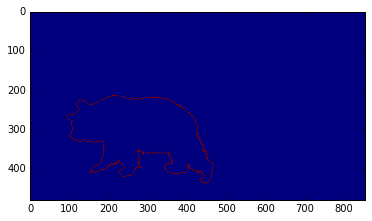

In [18]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_dilation 

%matplotlib inline

img = '../../../DAVIS17_train_val/Annotations/480p/bear/00000.png'
img = Image.open(img)
image = np.array(img, np.uint8)
img_bool = np.greater(image, 0)
img_bin = img_bool.astype(np.uint8)
img_g = np.gradient(img_bin)
img_g = np.transpose(img_g, [1,2,0])
print(np.shape(img_g))
img_boundary = np.greater(img_g[:,:,1] + img_g[:,:,0], 0).astype(np.uint8)
img_boundary = binary_dilation(img_boundary)
imgplot = plt.imshow(img_boundary)